In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/mathias/Documents/smartanalytics-city-98af3a209309.json"
import pandas as pd
import numpy as np


from google.cloud import bigquery

queryFrost = (
    "SELECT * "
    "FROM `smartanalytics-city.frost.frost_hour_training` "
    )
def fetch_frost_from_bigquery():
    bigquery_client = bigquery.Client()
    query_job = bigquery_client.query(queryFrost)
    print("Done fetching from bigquery")
    return query_job.result()


def get_frost_data():
    entities = []
    rows = fetch_frost_from_bigquery()
    for row in rows:
        entities.append(get_frost_as_dict(row))
    return pd.DataFrame.from_dict(entities)


def get_frost_as_dict(row):
    return {
            "datetime":  pd.to_datetime(row.datetime),
            "wind_speed": row.wind_speed,
            "air_temperature": row.air_temperature,
        "relative_humidity": row.relative_humidity,
        "wind_from_direction": row.wind_from_direction,
        "cloud_area_fraction": row.cloud_area_fraction,
        "precipitation_amount": row.precipitation_amount,
        'air_pressure_at_sea_level': row.air_pressure_at_sea_level
        }


queryAir = (
    "SELECT * "
    "FROM `smartanalytics-city.luftkvalitet.luftkvalitet_hour_training` "
    )
def fetch_air_from_bigquery():
    bigquery_client = bigquery.Client()
    query_job = bigquery_client.query(queryAir)
    print("Done fetching from bigquery")
    return query_job.result()


def get_air_data():
    entities = []
    rows = fetch_air_from_bigquery()
    for row in rows:
        entities.append(get_air_as_dict(row))
    return pd.DataFrame.from_dict(entities)


def get_air_as_dict(row):
    return {
            "datetime":  pd.to_datetime(row.datetime),
            "NOxHjortnes": row.NOxHjortnes,
            "NOxManglerud": row.NOxManglerud,
        "NOxSmestad": row.NOxSmestad,
        "NOxKirkeveien": row.NOxKirkeveien,
        "NOxE6Alna": row.NOxE6Alna,
        "NOxBygdoyAlle": row.NOxBygdoyAlle,
        "NOxBrynSkole": row.NOxBrynSkole
        }



In [3]:
dfLuft = get_air_data()
dfFrost = get_frost_data()

Done fetching from bigquery
Done fetching from bigquery


In [4]:
dfFrost=dfFrost[:-1].reset_index(drop=True)
dfLuft=dfLuft[1:].reset_index(drop=True)


# Change aggregation from day to hour

In [5]:
def cloudAggregateHour():
    clouds = dfFrost['cloud_area_fraction']
    value=0
    returnArray = []
    for i in range(len(clouds)):
        if not np.isnan(clouds[i]):
            value= clouds[i]
        returnArray.append(value)
            
    return np.array(returnArray)

def precipitationAggregateHour():
    prec = dfFrost['precipitation_amount']
    value=0
    returnArray = []
    for i in range(len(prec)):
        if not np.isnan(prec[i]):
            value= round(prec[i]/24,3)
            
        returnArray.append(value)
            
    return returnArray
    



In [6]:
import datetime

def getMonthArray(timeseries):
    monthArray=[]
    for i in range(len(timeseries)):
        monthArray.append(timeseries[i].month)
    return monthArray

def getSeasonArray(timseries,monthArray):
    seasonArray = []
    seasons = {
        1 : [12,1,2],
        2 : [3,4,5],
        3 : [6,7,8],
        4 : [9,10,11]

    }

    seasonDict = {}

    for key,value in seasons.items():
        for v in value:
            seasonDict[v]=key
    
    for m in monthArray:
        seasonArray.append(seasonDict[m])
    #print(seasonDict)
    return seasonArray

def getDayOfWeek(timeseries):
    weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
    days = []
    for date in timeseries:
        weekDayAsInt = date.weekday()

        days.append(weekDayAsInt)
    return days



import holidays

def getRedDaysAsBoolean(timeseries):
    redDays = []
    for i in range(len(timeseries)):
        currentDate = pd.to_datetime(timeseries[i])
        if currentDate in holidays.Norway() or (currentDate.day == 24 and currentDate.month == 12):

            redDays.append(1)
        else:
            redDays.append(0)
    return redDays
            
        
        
        
def getDaysOfYear(timeseries):
    daysOfYyear = []

    for i in range(len(timeseries)):
        currentDate = pd.to_datetime(timeseries[i])
        daysOfYyear.append(currentDate.timetuple().tm_yday)
    return daysOfYyear

def getHours(timeseries):
    hours = []
    for i in range(len(timeseries)):
        hours.append(timeseries[i].hour)
    return hours

t = pd.to_datetime(dfFrost['datetime'])
        
monthArray = getMonthArray(t)

weekdays = getDayOfWeek(t)
  
redDays = getRedDaysAsBoolean(t)
daysOfYear = getDaysOfYear(t)

seasons = getSeasonArray(t,monthArray)

clouds = cloudAggregateHour()

precs = precipitationAggregateHour()
hours = getHours(t)


In [7]:
len(precs)

22295

In [12]:
import seaborn as sns
def checkNaN(X):
    return X[np.isnan(X)]

dicty = {
    "hours": hours,
    "seasons":seasons,
    "monthArray": monthArray,
    "weekdays" : weekdays,
    "daysOfYear": daysOfYear,
    "redDays": redDays,
    "wind_speed": dfFrost["wind_speed"],
    "air_temperature": dfFrost['air_temperature'],
    "relative_humidity": dfFrost['relative_humidity'],
    'wind_from_direction': dfFrost['wind_from_direction'],
    'air_pressure_at_sea_level':dfFrost['air_pressure_at_sea_level'],
    "clouds" : clouds,
    "precipitation" :precs,
    "NOxHjortnes" : dfLuft['NOxHjortnes'],
    'NOxBygdoyAlle': dfLuft['NOxBygdoyAlle'],
    'NOxE6Alna' : dfLuft['NOxE6Alna'],
    'NOxKirkeveien': dfLuft['NOxKirkeveien'],
    'NOxManglerud': dfLuft['NOxManglerud'],
    'NOxSmestad' : dfLuft['NOxSmestad'],
    "NOxBrynSkole": dfLuft["NOxBrynSkole"]
}

df = pd.DataFrame.from_dict(dicty)

df.isna().sum()
df = df.dropna()

df.to_csv("data/dataset.csv",sep=';',index=False)

In [13]:
X = np.array([df['hours'],df['seasons'],df['monthArray'] ,df['weekdays'] ,df['daysOfYear'] ,df['redDays'] ,df['wind_speed'],df['air_temperature'],df['relative_humidity'],df['wind_from_direction'],df['clouds'], df['precipitation'],df['air_pressure_at_sea_level']])
Y = np.array([df['NOxHjortnes'],df['NOxBygdoyAlle'],df['NOxE6Alna'],df['NOxKirkeveien'], df['NOxManglerud'],df['NOxSmestad'],df["NOxBrynSkole"]])


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

standard_scaling = StandardScaler()

X_Standard = standard_scaling.fit_transform(X.T)
Y_Standard = standard_scaling.fit_transform(Y.T)



X_train, X_test, Y_train, Y_test = train_test_split(
    X.T, Y.T, test_size=0.05, random_state=41)


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import numpy.linalg as linalg

def getMSE(y_hat,y):
    return round((mse(y_hat,y)))

def plotResults(y_hat,y,category,fignum=1):
    NMSE = getMSE(y_hat,y)
    t = np.linspace(0,len(y),num=len(y))
    plt.figure(fignum,figsize=(20,10))
    
    plt.plot(t,y,color='cornflowerblue',label="True")
    plt.plot(t,y_hat,color='firebrick',label="Predicted")
    plt.legend()
    plt.title(f"{category}, NMSE: {NMSE}")
    

def scatterResults(y_hat,y,category,fignum=1):
    plt.figure(fignum,figsize=(10,10))
    NMSE = getMSE(y_hat,y)
    plt.scatter(y,y_hat)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    lims = [-5, 15]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.title(f"{category}, MSE: {NMSE}")
    

In [16]:
#X_train=X.T[:15300]
#Y_train = Y.T[:15300]
#X_test = X.T[15300:]
#Y_test = Y.T[15300:]
#len(X.T)

In [18]:
from sklearn.multioutput import MultiOutputRegressor


from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 50,max_depth = 8)

mor = MultiOutputRegressor(model)

mor.fit(X_train,Y_train)
Y_pred = mor.predict(X_test)



/home/mathias/.local/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [19]:
import joblib
joblib.dump(mor,"models/XGBoostNOx.sav")

['models/XGBoostNOx.sav']

In [257]:
# Normalizing
standard_scaling = StandardScaler()
Y_test = standard_scaling.fit_transform(Y_test)
Y_pred = standard_scaling.fit_transform(Y_pred)



array([[ 2.22493   ,  2.1169589 ,  3.1347091 , ...,  1.7620202 ,
         1.7817584 ,  2.8197303 ],
       [ 2.3950455 ,  3.4195302 ,  0.43701813, ...,  3.4892614 ,
         2.520261  ,  0.4413684 ],
       [-0.8657255 , -1.1937487 , -0.8315467 , ..., -1.2825481 ,
        -0.99155647, -0.7807976 ],
       ...,
       [ 0.96269256,  0.29045334,  0.5528646 , ...,  0.22379085,
         0.35274023, -0.2228637 ],
       [-0.67467827,  0.82258046, -0.18309633, ..., -0.10382549,
         0.7758678 ,  0.03308808],
       [-0.32080626, -0.18424225, -0.7757904 , ..., -0.28415877,
        -0.84452415, -1.0694999 ]], dtype=float32)

In [258]:

y_pred_Hjortnes = Y_pred.T[0]
y_pred_BygdoyAlle = Y_pred.T[1]
y_pred_E6Alna = Y_pred.T[2]
y_pred_Kirkeveien = Y_pred.T[3]
y_pred_Manglerud = Y_pred.T[4]
y_pred_Smestad = Y_pred.T[5]
y_pred_BrynSkole = Y_pred.T[6]

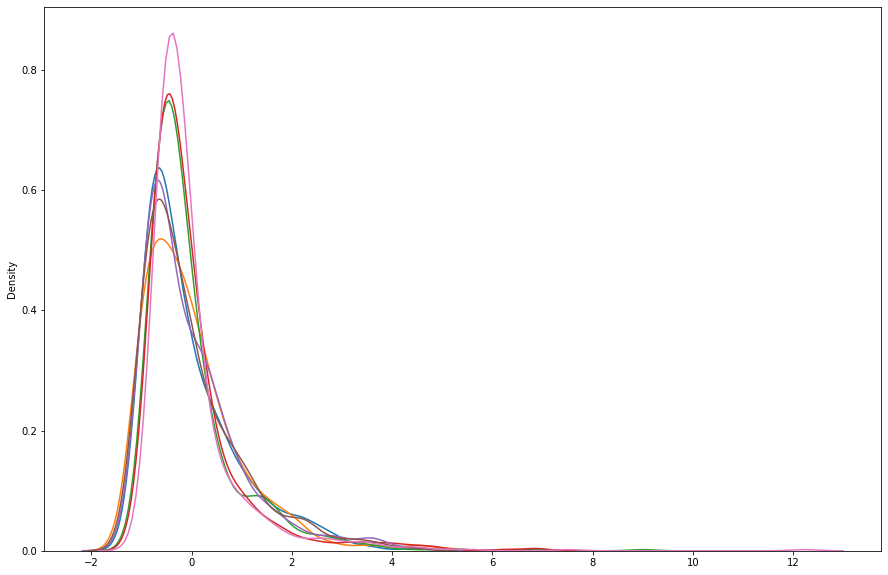

<Figure size 1080x720 with 0 Axes>

In [259]:
import seaborn as sns
plt.figure(1,figsize=(15,10))
sns.kdeplot(y_pred_Hjortnes)
sns.kdeplot(y_pred_BygdoyAlle)
sns.kdeplot(y_pred_E6Alna)
sns.kdeplot(y_pred_Kirkeveien)
sns.kdeplot(y_pred_Manglerud)
sns.kdeplot(y_pred_Smestad)
sns.kdeplot(y_pred_BrynSkole)



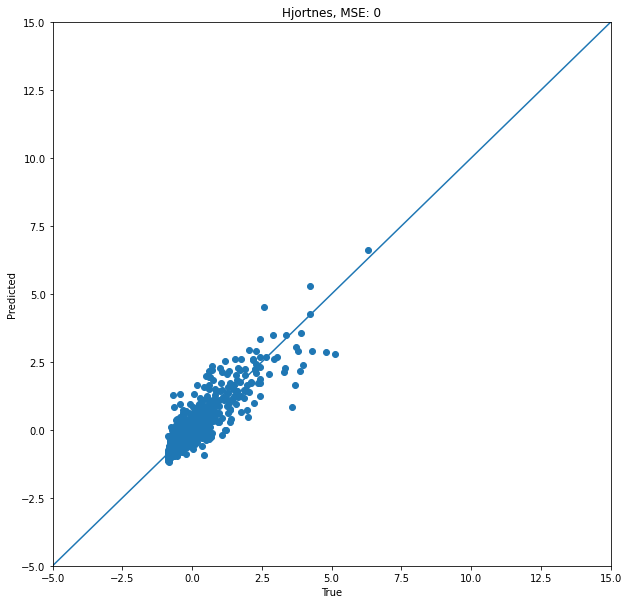

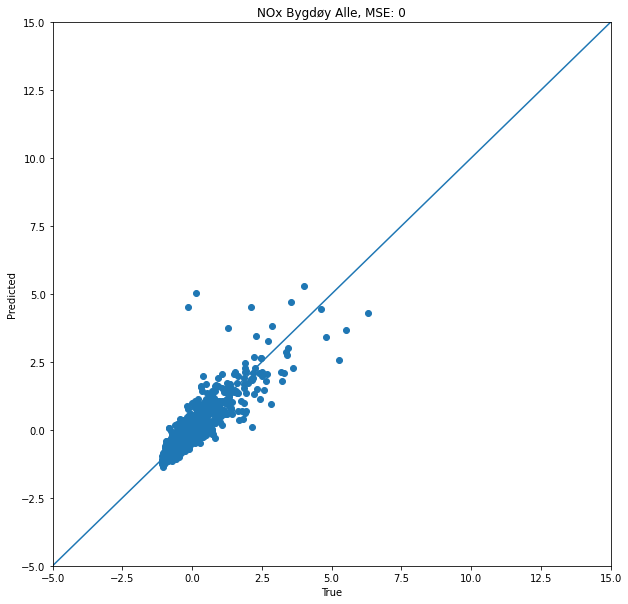

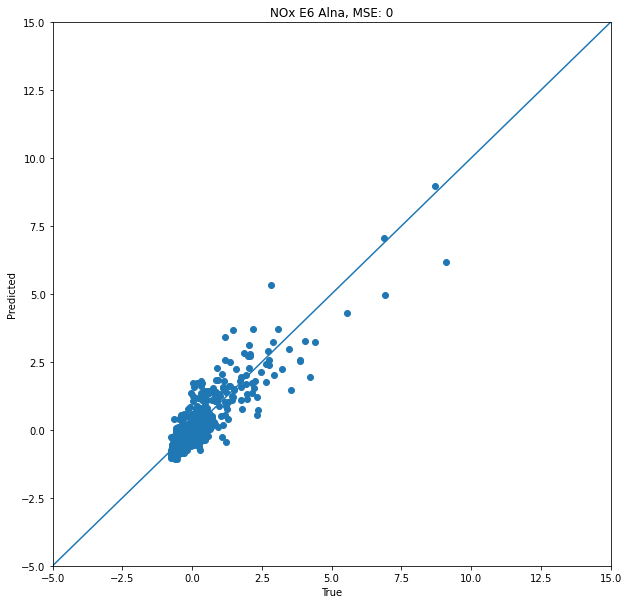

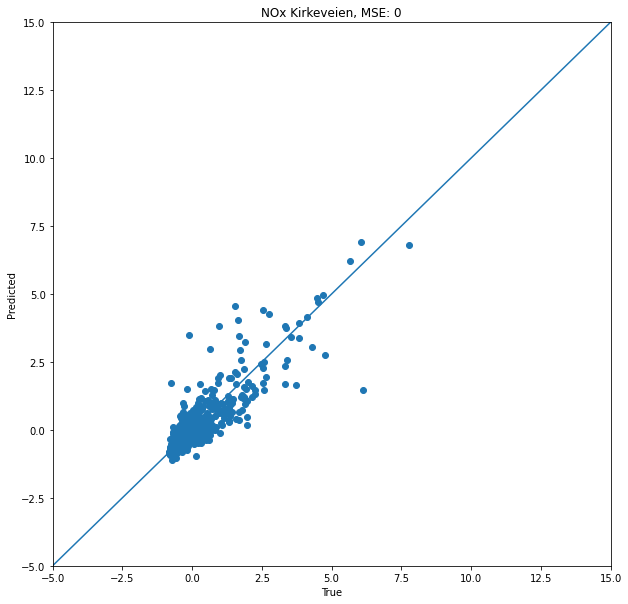

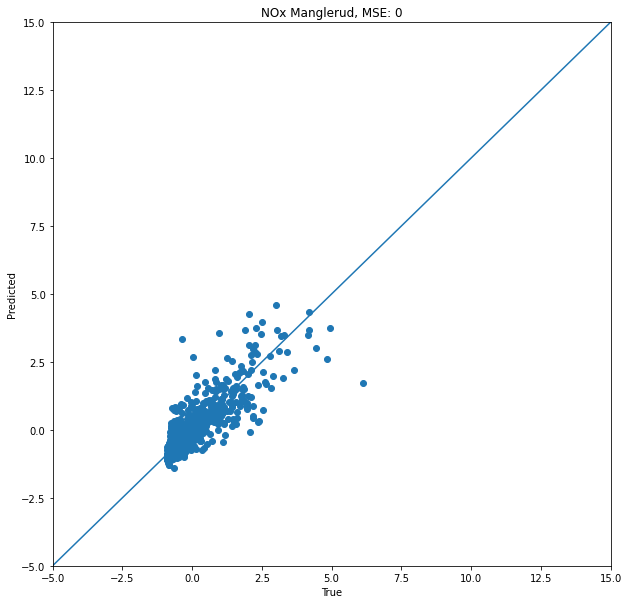

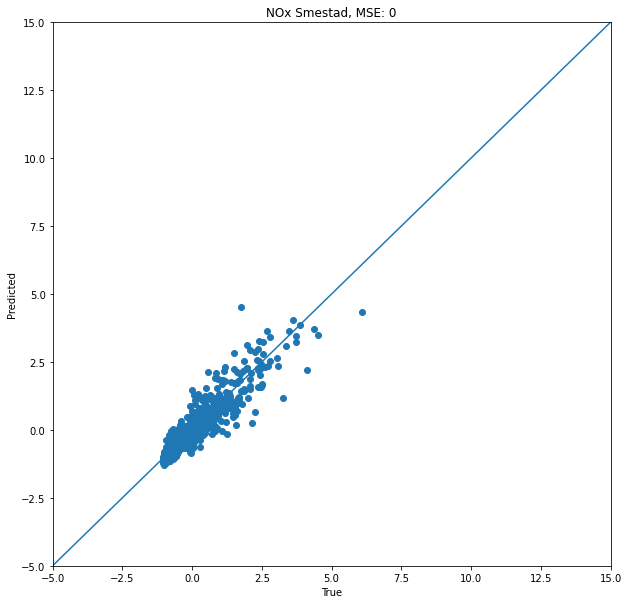

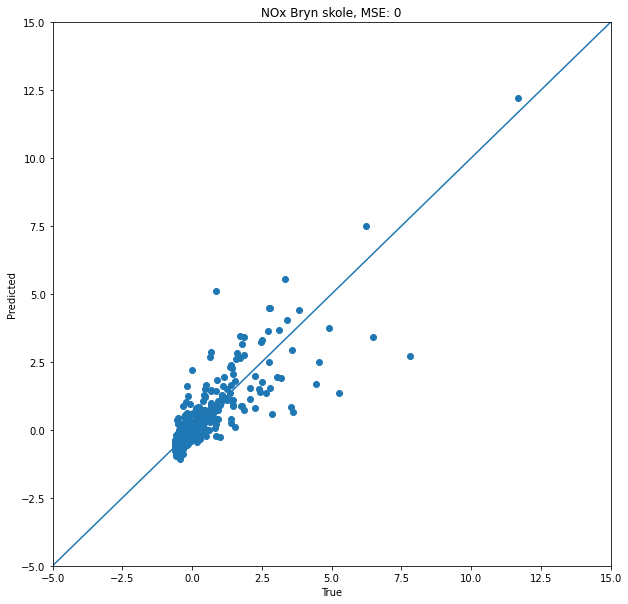

In [260]:
scatterResults(y_pred_Hjortnes,Y_test.T[0],"Hjortnes",1)
scatterResults(y_pred_BygdoyAlle,Y_test.T[1],"NOx Bygdøy Alle",2)
scatterResults(y_pred_E6Alna,Y_test.T[2],"NOx E6 Alna",3)
scatterResults(y_pred_Kirkeveien,Y_test.T[3],"NOx Kirkeveien",4)
scatterResults(y_pred_Manglerud,Y_test.T[4],"NOx Manglerud",5)
scatterResults(y_pred_Smestad,Y_test.T[5],"NOx Smestad",6)
scatterResults(y_pred_BrynSkole,Y_test.T[6],"NOx Bryn skole",7)


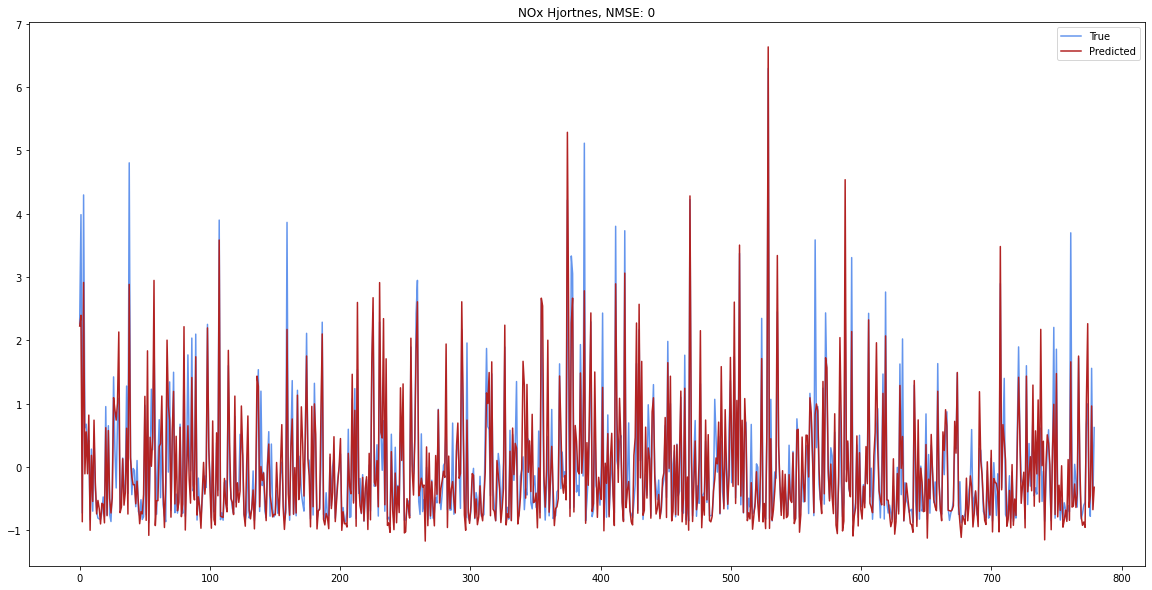

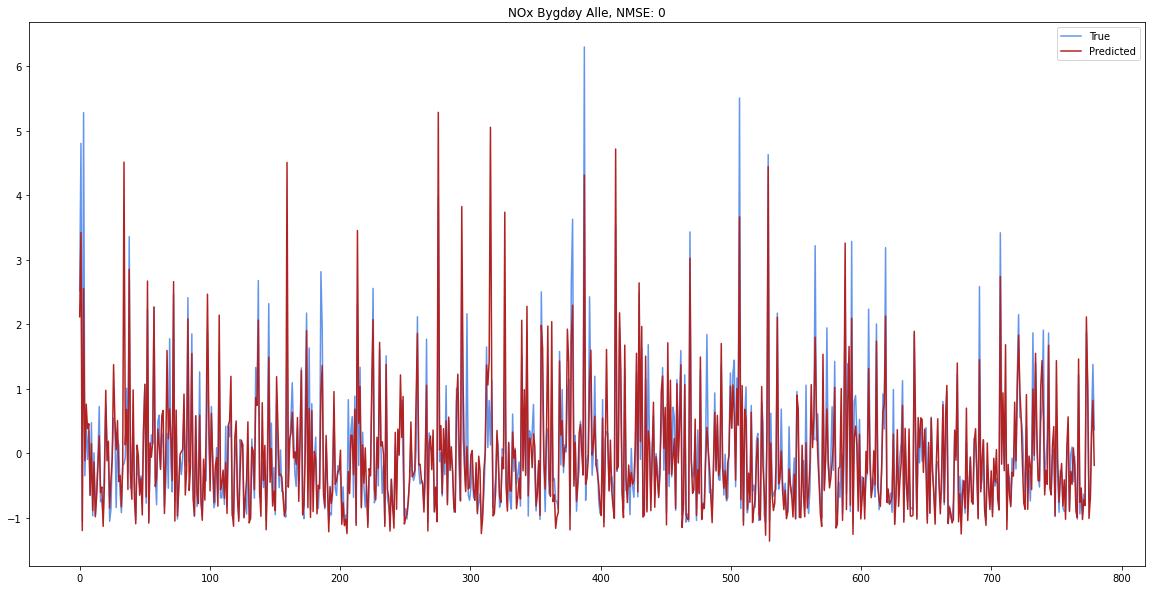

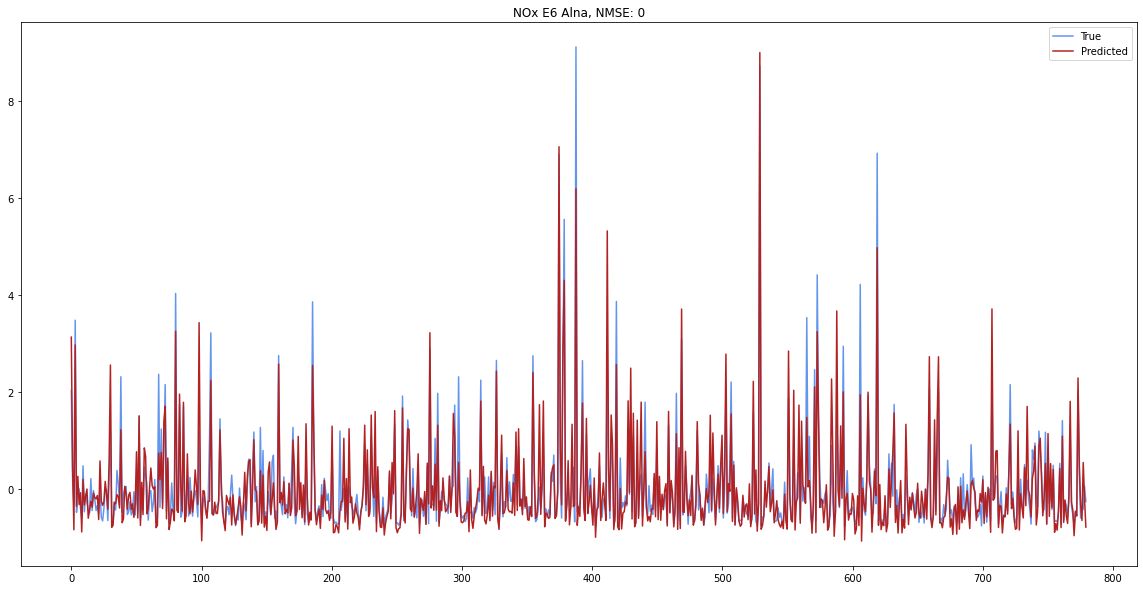

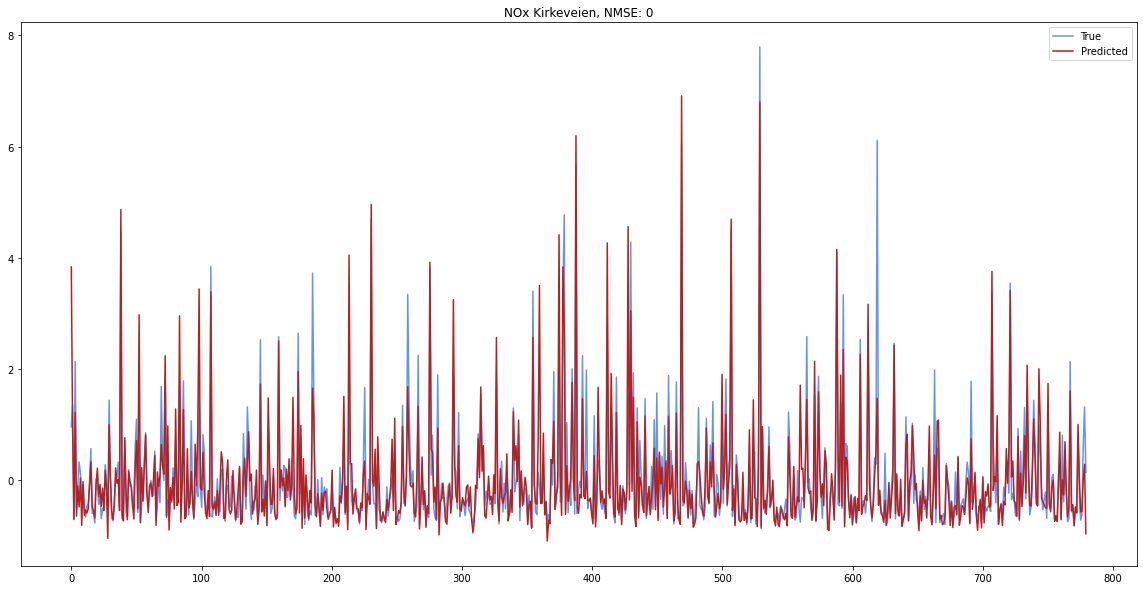

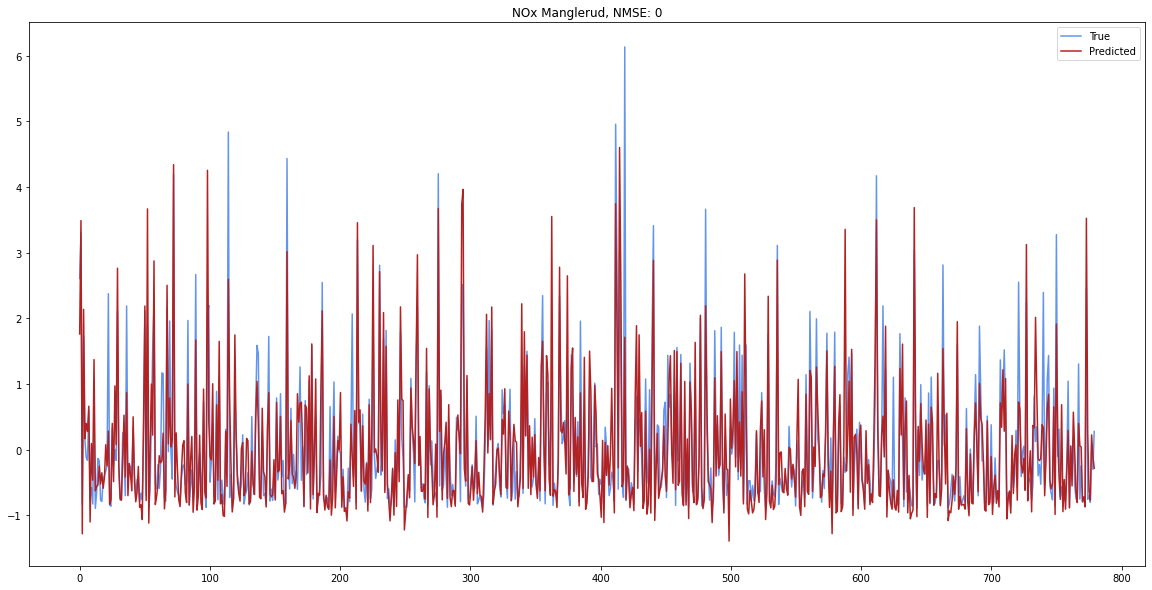

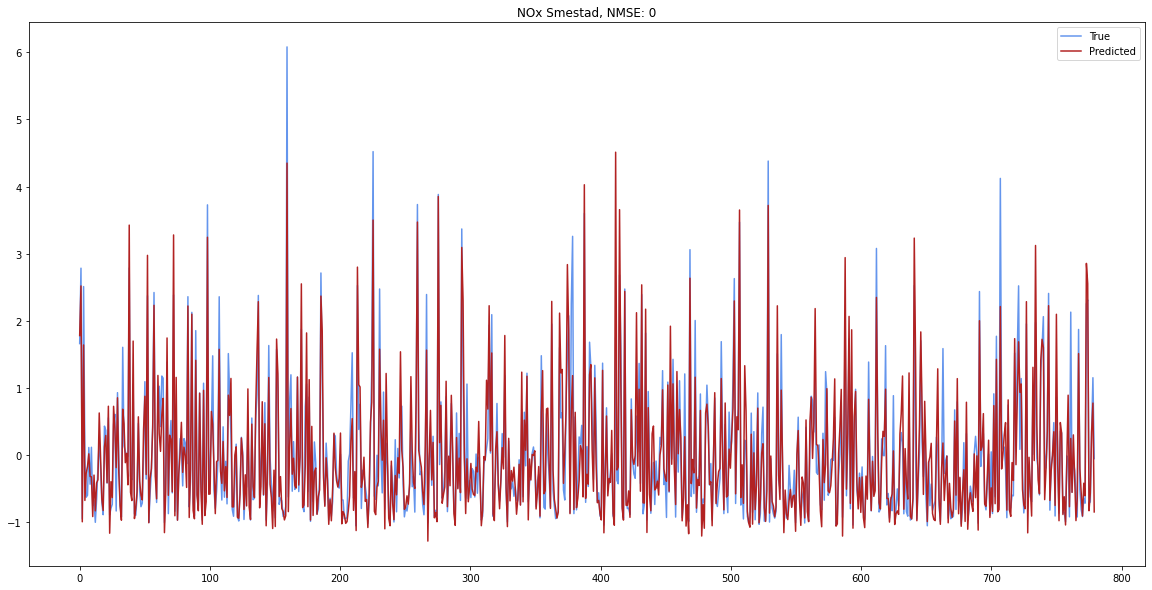

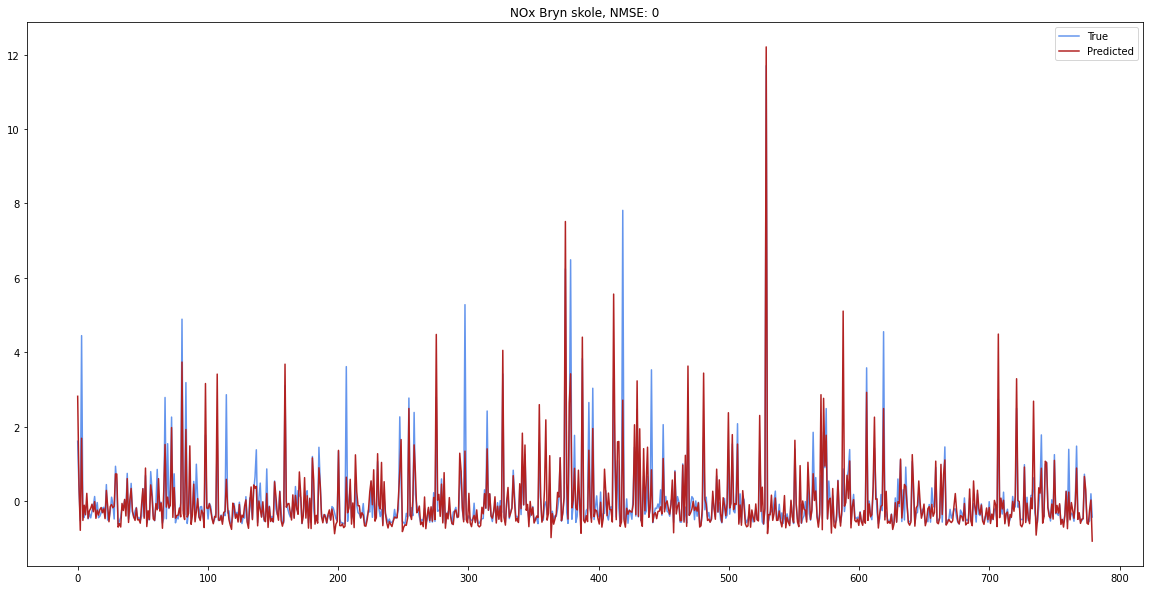

In [261]:

plotResults(y_pred_Hjortnes,Y_test.T[0],"NOx Hjortnes",1)
plotResults(y_pred_BygdoyAlle,Y_test.T[1],"NOx Bygdøy Alle",2)
plotResults(y_pred_E6Alna,Y_test.T[2],"NOx E6 Alna",3)
plotResults(y_pred_Kirkeveien,Y_test.T[3],"NOx Kirkeveien",4)
plotResults(y_pred_Manglerud,Y_test.T[4],"NOx Manglerud",5)
plotResults(y_pred_Smestad,Y_test.T[5],"NOx Smestad",6)
plotResults(y_pred_BrynSkole,Y_test.T[6],"NOx Bryn skole",7)


